# Using a Modflow UZF model as a stressmodel in Pastas

In [2]:
import os

import flopy
import pandas as pd
import pastas as ps

import pastas_plugins.modflow as ppmf

from pastas.timer import SolveTimer

ps.set_log_level("ERROR")

bindir = "bin"
mf6_exe = os.path.join(bindir, "mf6")
if not os.path.isfile(mf6_exe):
    if not os.path.isdir(bindir):
        os.makedirs(bindir)
    flopy.utils.get_modflow("bin", repo="modflow6")

## Data

In [5]:
head.index

DatetimeIndex(['2003-01-01', '2003-01-02', '2003-01-03', '2003-01-04',
               '2003-01-05', '2003-01-06', '2003-01-07', '2003-01-08',
               '2003-01-09', '2003-01-10',
               ...
               '2018-12-16', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-22', '2018-12-23',
               '2018-12-24', '2018-12-25'],
              dtype='datetime64[ns]', name='Date', length=5737, freq=None)

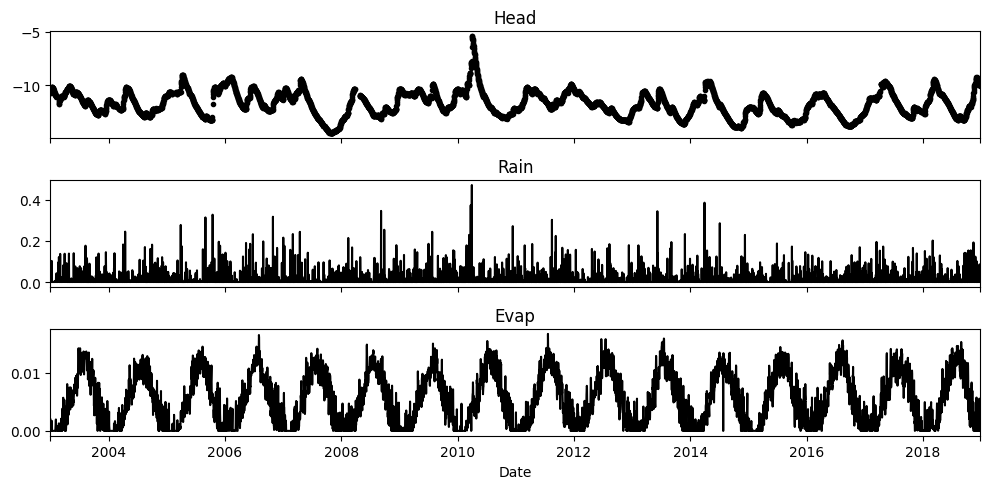

In [9]:
# ds = ps.load_dataset("collenteur_2019")
# head = ds["head"].squeeze()
# prec = ds["rain"].squeeze().resample("D").asfreq().fillna(0.0)
# evap = ds["evap"].squeeze()

head = pd.read_csv("data/obs.csv", index_col=0, parse_dates=True).squeeze()
prec = pd.read_csv("data/rain.csv", index_col=0, parse_dates=True).squeeze().resample("D").asfreq().fillna(0.0)
evap = pd.read_csv("data/evap.csv", index_col=0, parse_dates=True).squeeze()

tmin = pd.Timestamp("2003-01-01")
tmax = pd.Timestamp("2018-12-25")

tmin_wu = tmin - pd.Timedelta(days=365*4)
# tmin_wu = pd.Timestamp("1986-01-01")

ps.plots.series(head, [prec, evap], hist=False);

## Time series models

### Standard exponential model

Fit report Head                   Fit Statistics
nfev    11                     EVP         87.10
nobs    5737                   R2           0.87
noise   False                  RMSE         0.42
tmin    2003-01-01 00:00:00    AICc     -9870.13
tmax    2018-12-25 00:00:00    BIC      -9843.52
freq    D                      Obj        512.71
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal    initial  vary
test_exp_A  331.311203  29.925748  True
test_exp_a   98.430976  10.000000  True
test_exp_f   -0.854493  -1.000000  True
constant_d  -14.150486 -11.740288  True


<Axes: xlabel='Date', ylabel='Head'>

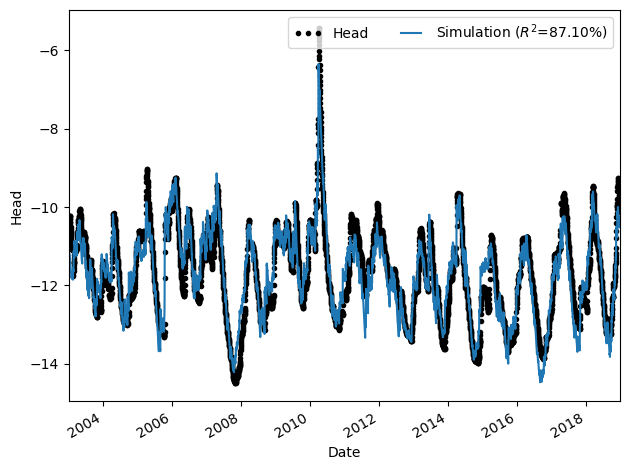

In [10]:
mlexp = ps.Model(head)
mlexp.add_stressmodel(
    ps.RechargeModel(prec=prec, evap=evap, rfunc=ps.Exponential(), name="test_exp")
)
mlexp.solve(tmin=tmin, tmax=tmax)
mlexp.plot()

### UZF Model

<Axes: xlabel='Date'>

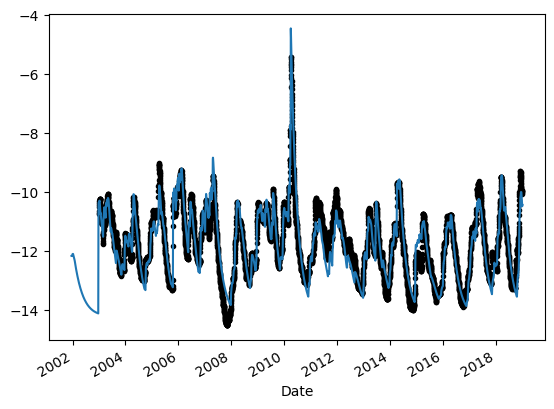

In [11]:
mlumf = ps.Model(head)

expmf = ppmf.ModflowUzf(exe_name=mf6_exe, sim_ws="mf_files/test_umf", head=head)
expsm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=expmf, name="test_expmfsm")
mlumf.add_stressmodel(expsm)
mlumf.set_parameter(f"{expsm.name}_s", initial=0.27, vary=False)
mlumf.set_parameter(f"{expsm.name}_c", initial=340.0, vary=False)
constant_d = -14.23
if "constant_d" in mlumf.parameters.index:
    mlumf.set_parameter("constant_d", initial=constant_d, vary=False)
    if expmf._head is not None:
        mlumf.del_constant()
        mlumf.set_parameter(f"{expsm.name}_d", initial=constant_d, vary=False)
mlumf.set_parameter(f"{expsm.name}_height", initial=10.0, vary=False)

mlumf.settings["warmup"] = pd.Timedelta(days=4 * 365)
sim = mlumf.simulate()
ax = mlumf.observations().plot(marker=".", color="k", linestyle="None", legend=False)
sim.plot(ax=ax)

In [16]:
mlumf.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
test_expmfsm_d,-14.23,-14.500,-5.420000e+00,False,test_expmfsm,uniform,NaN,NaN
test_expmfsm_c,340.00,10.000,1.000000e+08,False,test_expmfsm,uniform,NaN,NaN
test_expmfsm_s,0.27,0.001,5.000000e-01,False,test_expmfsm,uniform,NaN,NaN
test_expmfsm_height,10.00,0.010,1.000000e+01,False,test_expmfsm,uniform,NaN,NaN
test_expmfsm_vks,1.00,0.000,1.000000e+01,True,test_expmfsm,uniform,NaN,NaN
test_expmfsm_thtr,0.10,0.000,2.000000e-01,True,test_expmfsm,uniform,NaN,NaN
test_expmfsm_thts,0.30,0.200,4.000000e-01,True,test_expmfsm,uniform,NaN,NaN
test_expmfsm_eps,5.00,3.500,1.000000e+01,True,test_expmfsm,uniform,NaN,NaN
test_expmfsm_extdpfrac,0.50,0.000,1.000000e+00,True,test_expmfsm,uniform,NaN,NaN


### UZF Model calibrated

In [14]:
ml = ps.Model(head)
ml.del_constant()
# shorten the warmup to speed up the modflow calculation somewhat.
ml.settings["warmup"] = pd.Timedelta(days=4 * 365)
mf = ppmf.ModflowUzf(exe_name=mf6_exe, sim_ws="mf_files/test_mfuzf", head=head, ntrailwaves=35, nwavesets=200)
sm = ppmf.ModflowModel(prec, evap, modflow=mf, name="mfsm")
ml.add_stressmodel(sm)

ml.set_parameter(f"{sm.name}_d", pmin=-15.0)

with SolveTimer() as st:
    ml.solve(callback=st.timer, tmin=tmin, tmax=tmax, diff_step=0.1)

Optimization progress: 0it [00:00, ?it/s]

Optimization progress: 271it [24:56,  5.52s/it]

Fit report Head                    Fit Statistics
nfev    37                     EVP          91.27
nobs    5737                   R2            0.91
noise   False                  RMSE          0.35
tmin    2003-01-01 00:00:00    AICc     -12099.39
tmax    2018-12-25 00:00:00    BIC      -12039.53
freq    D                      Obj         347.02
warmup  1460 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (9 optimized)
                   optimal     initial  vary
mfsm_d          -14.387198  -11.740288  True
mfsm_c          333.878149  220.000000  True
mfsm_s            0.270532    0.050000  True
mfsm_height       8.207098    1.000000  True
mfsm_vks          0.563144    1.000000  True
mfsm_thtr         0.066735    0.100000  True
mfsm_thts         0.202197    0.300000  True
mfsm_eps          3.719373    5.000000  True
mfsm_extdpfrac    0.993822    0.500000  True

Warnings! (1)
Response tmax for 'mfsm' > than calibration period.


(12783.0, 17890.0)

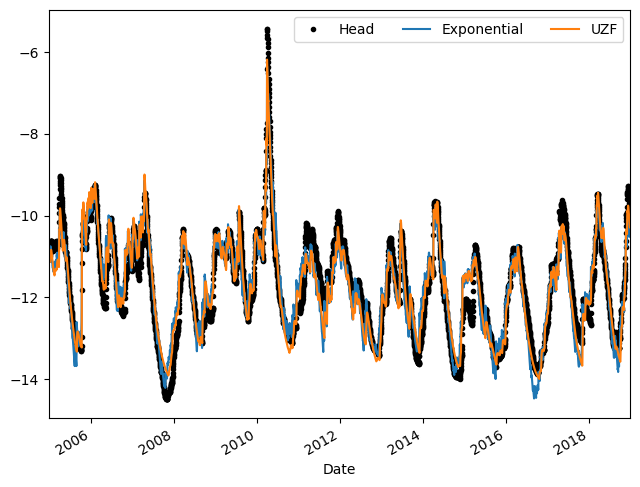

In [17]:
ax = ml.observations().plot(marker=".", color="k", linestyle="None", legend=False, figsize=(7.5, 6))
mlexp.simulate().plot(ax=ax, label="Exponential")
ml.simulate().plot(ax=ax, label="UZF")
ax.legend(ncol=3, loc="upper right")
ax.set_xlim(tmin+pd.Timedelta(days=2*365), tmax)